In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
train["data"] = "train"
test["data"] = "test"
dataset = pd.concat([train, test], axis=0).reset_index(drop=True)
dataset["subject"] = "#" + dataset["subject"].astype(str)

In [36]:
train.shape, test.shape

((7352, 564), (2947, 564))

In [47]:
dataset.head()

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X',
 'tBodyAcc-max()-Y',
 'tBodyAcc-max()-Z',
 'tBodyAcc-min()-X',
 'tBodyAcc-min()-Y',
 'tBodyAcc-min()-Z',
 'tBodyAcc-sma()',
 'tBodyAcc-energy()-X',
 'tBodyAcc-energy()-Y',
 'tBodyAcc-energy()-Z',
 'tBodyAcc-iqr()-X',
 'tBodyAcc-iqr()-Y',
 'tBodyAcc-iqr()-Z',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,1',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,1',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,1',
 'tBodyAcc-arCoeff()-Z,2',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tGravityAcc-mean()-X',
 'tGravityA

In [38]:
dataset.dtypes.value_counts()

float64    561
object       3
Name: count, dtype: int64

In [39]:
def basicDetails(df):
    b = pd.DataFrame()
    b["N of missing values"] = df.isnull().sum()
    b["N of unique values"] = df.nunique()
    b["data types"] = df.dtypes
    return b


basicDetails(dataset)

,N of missing values,N of unique values,data types
tBodyAcc-mean()-X,0,10292,float64
tBodyAcc-mean()-Y,0,10299,float64
tBodyAcc-mean()-Z,0,10293,float64
tBodyAcc-std()-X,0,10295,float64
tBodyAcc-std()-Y,0,10297,float64
...,...,...,...
"angle(Y,gravityMean)",0,10299,float64
"angle(Z,gravityMean)",0,10299,float64
subject,0,30,object
Activity,0,6,object


<BarContainer object of 6 artists>

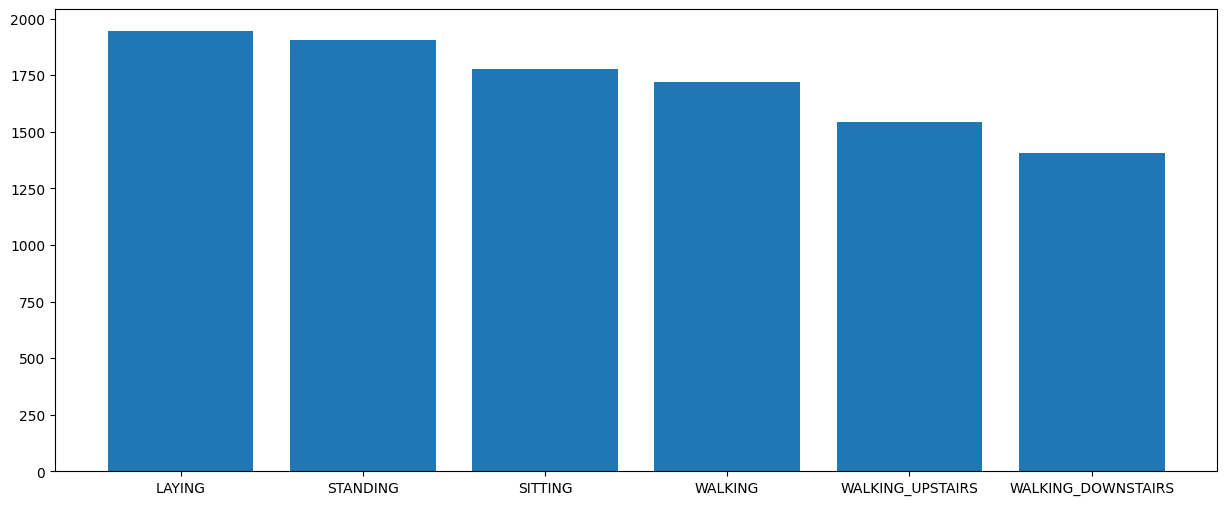

In [40]:
activity = dataset["Activity"]
label_counts = activity.value_counts()

plt.figure(figsize=(15, 6))
plt.bar(label_counts.index, label_counts)

In [41]:
data = dataset["data"]
subject = dataset["subject"]
train = dataset.copy()
train = train.drop(["data", "subject", "Activity"], axis=1)

In [42]:
# Readying the data by normalizing
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
train = scl.fit_transform(train)

# Reduscing dimensions to avoid information redundancy
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=0)
train = pca.fit_transform(train)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    train, activity, test_size=0.2, random_state=0
)

First we'll classify this data using k-nearest neighbors algorithm


In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

modelKNN = KNeighborsClassifier(
    n_neighbors=4, weights="distance", algorithm="auto", p=1
)
modelKNN.fit(X_train, Y_train)
Y_predict = modelKNN.predict(X_test)

print(classification_report(Y_test, Y_predict))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       377
           SITTING       0.93      0.91      0.92       364
          STANDING       0.92      0.94      0.93       390
           WALKING       0.96      1.00      0.98       335
WALKING_DOWNSTAIRS       0.99      0.96      0.97       278
  WALKING_UPSTAIRS       1.00      0.98      0.99       316

          accuracy                           0.96      2060
         macro avg       0.96      0.96      0.96      2060
      weighted avg       0.96      0.96      0.96      2060

